In [258]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [190]:
motes = ["0024","003a","0047","003f","0046","004a","0024","0048","0055","0037","004f","0040","002f"]
motedict = {}
for m in motes:
    df = pd.read_csv("soda_data/{0}.csv".format(m),names=[0,m])
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ns'))
    df = df.resample('30s').min()
    motedict[m] = df
for m, df in motedict.items():
    print df.count()

0048    16633
dtype: int64
0024    8304
dtype: int64
0040    16615
dtype: int64
0037    16618
dtype: int64
0046    16624
dtype: int64
0047    16630
dtype: int64
002f    16621
dtype: int64
0055    16601
dtype: int64
004a    16635
dtype: int64
003f    16236
dtype: int64
003a    16636
dtype: int64
004f    16603
dtype: int64


16639


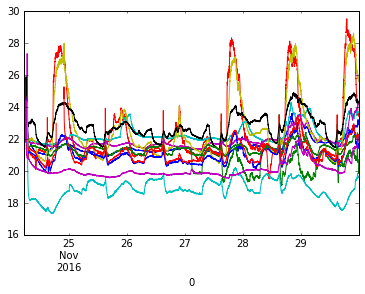

In [191]:
# merge
dfs = motedict.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

 11
[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)] 55
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)]
55


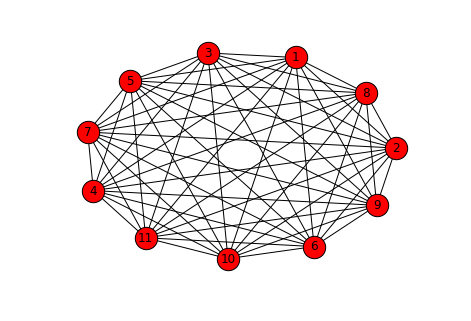

In [240]:
# need the soda printout map!  Then we assign nodes, etc
mote_mapping = {
    '0047': 1,
    '002f': 2,
    '0037': 3,
    '004f': 4,
    '0048': 5,
    '004a': 7,
    '0046': 8,
    '003a': 9,
    '0024': 10,
    '0055': 11
}
edges = [
    (1,2),
    (2,6),
    (2,3),
    (3,6),
    (4,6),
    (5,6),
    (6,7),
    (6,8),
    (9,10),
    (10,11),
    (11,6)
]
physical_edges = edges
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, iterations=500, k=2.0, scale=10.0)
#nx.draw(G,pos,node_size=500,with_labels=True)
nodes = G.nodes()
minNode = min(nodes)
edges = G.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('soda_amplab_edges.mat',{'edges': e})

import itertools
edges = list(itertools.combinations(range(1,12),2))
full_edges = edges
print edges,len(edges)
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, iterations=500, k=2.0, scale=10.0)
nx.draw(G,pos,node_size=500,with_labels=True)
nodes = G.nodes()
minNode = min(nodes)
edges = G.edges()
print nodes
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
print edges
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('soda_amplab_edges.mat',{'edges': e})

In [193]:
# want to rename the data columns in terms of which node in the graph they are
# also need data for all of the nodes: "easiest" way is to take average of temperatures of nearby nodes
# This is what gets put in 'sdh_idea1.csv'

# First take our empirical data and replace the keti ids with the node ids
current = current[mote_mapping.keys()].rename(columns=mote_mapping)
# Now we need to "fill" the graph: For each node for which we have original data (make this list at the beginning),
# we do a breadth-first traversal through the tree. At each node we visit, its temperature becomes the average of
# its neighboring nodes; if the node's neighbors do not have any values, then we just use the value we are
# propagating from; if the node already has a value (that's not an empirical value), then its new value is the
# average of its new temperature and its neighbors (using the propagating value if neighbors have no values)
empirical_nodes = current.columns
print empirical_nodes
data_row = current.iloc[0]
result = pd.DataFrame()
rownum = 0
t = datetime.now()
for row in current.iterrows():
    rownum += 1
    for en in empirical_nodes:
        data_row = row[1]
        if pd.isnull(data_row[en]):
            #print en,'has no data'
            continue
        propagate_point = data_row[en]
        bfs_edges = nx.algorithms.traversal.bfs_edges(G, en)
        # the 2nd item (index 1) of each edge is the next node
        bfs_nodes = [x[1] for x in bfs_edges if x[1] not in empirical_nodes or pd.isnull(data_row[x[1]])]
        for node in bfs_nodes:
            neighbors = G.neighbors(node)
            # get data from neighbors
            datas = [data_row.get(n, propagate_point) for n in neighbors]
            # get data from ourself
            datas.append(data_row.get(node, propagate_point))
            # filter out nans
            datas = filter(lambda x: not pd.isnull(x), datas)
            data_row[node] = np.mean(datas)
    if rownum % 1000 == 0:
        print rownum, len(current), (datetime.now()-t).total_seconds()
        t = datetime.now()
    result = result.append(data_row)

Int64Index([5, 2, 8, 10, 11, 7, 3, 9, 4, 1], dtype='int64')
1000 16639 7.556524
2000 16639 7.514513
3000 16639 7.694534
4000 16639 7.415187
5000 16639 7.78582
6000 16639 7.480972
7000 16639 7.372016
8000 16639 7.564374
9000 16639 7.614174
10000 16639 7.375585
11000 16639 7.473729
12000 16639 7.910506
13000 16639 7.458583
14000 16639 7.658599
15000 16639 7.28929
16000 16639 7.394037


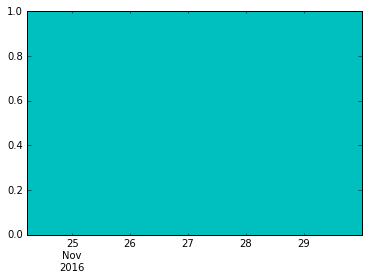

In [194]:
# compute whether or not temperature going up or not
df = result.copy()
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = 0
diffs = diffs.fillna(0)
diffs.plot(legend=False)
diffs.tail()
diffs.to_csv("soda_amplab_data.csv",sep="\t",header=False,index=False)

In [62]:
# TODO: need a method that takes the log likelihood and theta from the
# output and then associates them with the edges
# TODO: compare different methods and look at their log-likelihoods (which one maximizes?!)
# TODO: make the list of figures you will have

In [63]:
def dump(edges, theta):
    res = ""
    for i, e in enumerate(edges):
        res += '\nEdge {0} => {1}'.format(e, str(theta[i]).replace('\n','\n\t\t'))
    print res

### Figures to Generate

Likelihood plots:
- likelihood (y axis) vs bucket (x axis); overlay min/mean/max

Visualize the thetas:
- some sort of confusion matrix plot?

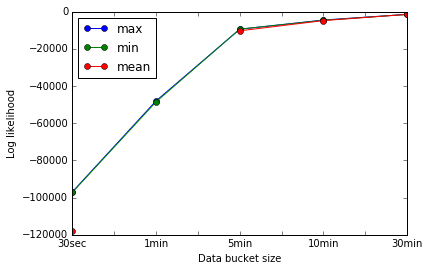

In [208]:
soda_mean_likelihoods = {
    '10min': -4840.9,
    '5min': -10319,
    '30min': -1494,
    '30sec': -118180,
}
soda_min_likelihoods = {
    '10min': -4658.3,
    '5min': -9423.7,
    '1min': -48513,
    '30sec': -97156,
    '30min': -1504,
}
soda_max_likelihoods = {
    '30min': -1487.6,
    '10min': -4532,
    '5min': -9476.3,
    '1min': -48019,
    '30sec': -96943,
}
dfmax = pd.DataFrame.from_dict(soda_max_likelihoods, orient='index')
dfmax.columns = ['max']
dfmin = pd.DataFrame.from_dict(soda_min_likelihoods, orient='index')
dfmin.columns = ['min']
dfmean = pd.DataFrame.from_dict(soda_mean_likelihoods, orient='index')
dfmean.columns = ['mean']
sodadf = pd.merge(dfmax, dfmin, left_index=True, right_index=True,how='left')
sodadf = pd.merge(sodadf, dfmean, left_index=True, right_index=True,how='left')
sodadf = sodadf.reindex(['30sec','1min','5min','10min','30min'])
fig = sodadf.plot(style='-o')
fig.set_ylabel('Log likelihood')
fig.set_xlabel('Data bucket size')

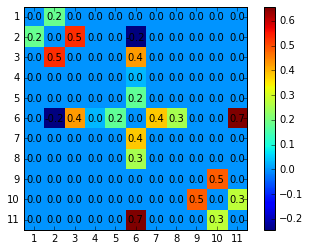

In [279]:
# grab entries from the thetas
def get_entries(bucket, sample, edges, nodes, coord):
    rows = [[] for n in nodes]
    filefmt = 'soda_amplab_{0}_{1}_theta'.format(bucket, sample)
    theta = np.loadtxt(filefmt, skiprows=5)
    num_edges = len(theta) / 4
    theta = theta.reshape(num_edges,2,2)
    for rownode in nodes:
        for colnode in nodes:
            e1 = (rownode, colnode)
            e2 = (colnode, rownode)
            e = None
            if e1 in edges:
                e = e1
            elif e2 in edges:
                e = e2
            else:
                rows[rownode-1].append(0)
                continue
            tt = theta[edges.index(e)]
            rows[rownode-1].append(tt[coord])
    rows = np.array(rows)

    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(rows), cmap=plt.cm.jet, 
                    interpolation='nearest')

    width, height = rows.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate('{:.1f}'.format(rows[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    b = fig.colorbar(res)
    plt.xticks(range(width), nodes[:width])
    plt.yticks(range(height), nodes[:height])
get_entries('30min','min', physical_edges, range(1,12), (1,1))

Soda hall figures:

- 1, 5, 10, 30 min resolution
- min/max/mean bucket
- 'structured' vs fully connected

In [227]:
# RESULTS
# loglikelihood =  -4840.9
theta = np.loadtxt('soda_amplab_10min_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)
# TODO: networkx code to visualizeeeeee

In [226]:
# loglikelihood = -10319
theta = np.loadtxt('soda_amplab_5min_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [225]:
# loglikelihood = -1494.0
# 30m
theta = np.loadtxt('soda_amplab_30min_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [224]:
# loglikelihood = -118180
# 30s
theta = np.loadtxt('soda_amplab_30sec_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [223]:
# loglikelihood = -1504.0
# 30min min
theta = np.loadtxt('soda_amplab_30min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [222]:
# loglikelihood = -4658.3
# 10min min
theta = np.loadtxt('soda_amplab_10min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [221]:
# ll = -9423.7 
# 5min min
theta = np.loadtxt('soda_amplab_5min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [220]:
# ll =   -48513
# 1min min
theta = np.loadtxt('soda_amplab_1min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [219]:
# -97156
# 30sec min
theta = np.loadtxt('soda_amplab_30sec_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [218]:
# MAX
# ll = -1487.6 
# 30min max
theta = np.loadtxt('soda_amplab_30min_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [217]:
# ll = -4532.0
# 10min max
theta = np.loadtxt('soda_amplab_10min_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [216]:
# ll = -9476.3
# 5min max
theta = np.loadtxt('soda_amplab_5min_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [215]:
# ll =  -48019
# 1min max
theta = np.loadtxt('soda_amplab_1min_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [214]:
# ll = -96943
# 30s max
theta = np.loadtxt('soda_amplab_30sec_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

## Fully Connected

In [213]:
# ll = -1324.0
# 30min mean
theta = np.loadtxt('soda_amplab_30min_mean_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [174]:
# ll = -4417.4
# 10min mean
theta = np.loadtxt('soda_amplab_10min_mean_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [173]:
# ll = -9642.5
# 5min mean
theta = np.loadtxt('soda_amplab_5min_mean_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [172]:
# ll = -57480
# 1min mean
theta = np.loadtxt('soda_amplab_1min_mean_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [171]:
# ll = -115530
# 30sec mean
theta = np.loadtxt('soda_amplab_30sec_mean_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [209]:
# ll = -4339.1
# 10min min 
theta = np.loadtxt('soda_amplab_10min_min_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [210]:
# ll = -8936.8
# 5min min
theta = np.loadtxt('soda_amplab_5min_min_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [211]:
# ll = -47457
# 1min min
theta = np.loadtxt('soda_amplab_1min_min_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)

In [212]:
# ll =   -95584
# 30sec min
theta = np.loadtxt('soda_amplab_30sec_min_full_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
#dump(edges, theta)